In [20]:
import numpy as np
import sys
import os
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
sys.path.append(os.path.abspath('C:/Users/vpming/tuni_ml/src'))
from extract_data import build_cellwise_df_10samplesperfile
from extract_cell_timetrace import extract_cell_timetrace
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [21]:
data_path = 'C:/Users/vpming/tuni_ml/data'
df = build_cellwise_df_10samplesperfile(data_path)

In [22]:
x = np.stack(df['time_trace'])

y = df['dis_to_target'].values

# 4 classes: 0, 1, 2, 3
n_bins = 4
bins = np.linspace(y.min(), y.max(), n_bins + 1)
y_class = np.digitize(y, bins[1:-1])  # produces class labels 0,1,2,3

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2, random_state=42)

# Scale only the input features
x_scaler = StandardScaler()
x_train_s = x_scaler.fit_transform(x_train)
x_test_s = x_scaler.transform(x_test)

# Do NOT scale y for classification!
train_ds = TensorDataset(torch.tensor(x_train_s, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(x_test_s, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [23]:
class CNNClassifier(nn.Module):
    def __init__(self, n_timepoints, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * (n_timepoints // 4), 64),
            nn.ReLU(),
            nn.Linear(64, n_classes) 
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        return self.fc(x)  

In [25]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels

In [26]:
def fit(model, train_loader, test_loader, epochs=30):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = running_loss / total
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        # Evaluate on test
        test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}  Train Accuracy: {acc:.2f}%  Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.2f}%')
        
    torch.save({
        'model_state_dict': model.state_dict()
    }, "C:/Users/vpming/tuni_ml/src/model/cnn_classifier_dtt.pt")

    # Plot losses and accuracies
    epochs_range = np.arange(1, epochs+1)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    # Confusion matrix for final test predictions
    plt.subplot(1, 3, 3)
    conf_mat = confusion_matrix(test_labels, test_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

Epoch 5/30 Train Loss: 0.6794  Train Accuracy: 67.20%  Test Loss: 0.7088  Test Accuracy: 65.52%
Epoch 10/30 Train Loss: 0.5004  Train Accuracy: 77.27%  Test Loss: 0.8633  Test Accuracy: 63.82%
Epoch 15/30 Train Loss: 0.2156  Train Accuracy: 91.56%  Test Loss: 1.4942  Test Accuracy: 60.10%
Epoch 20/30 Train Loss: 0.0572  Train Accuracy: 98.29%  Test Loss: 2.6786  Test Accuracy: 58.52%
Epoch 25/30 Train Loss: 0.0224  Train Accuracy: 99.41%  Test Loss: 3.3742  Test Accuracy: 59.44%
Epoch 30/30 Train Loss: 0.0247  Train Accuracy: 99.34%  Test Loss: 3.7470  Test Accuracy: 60.00%


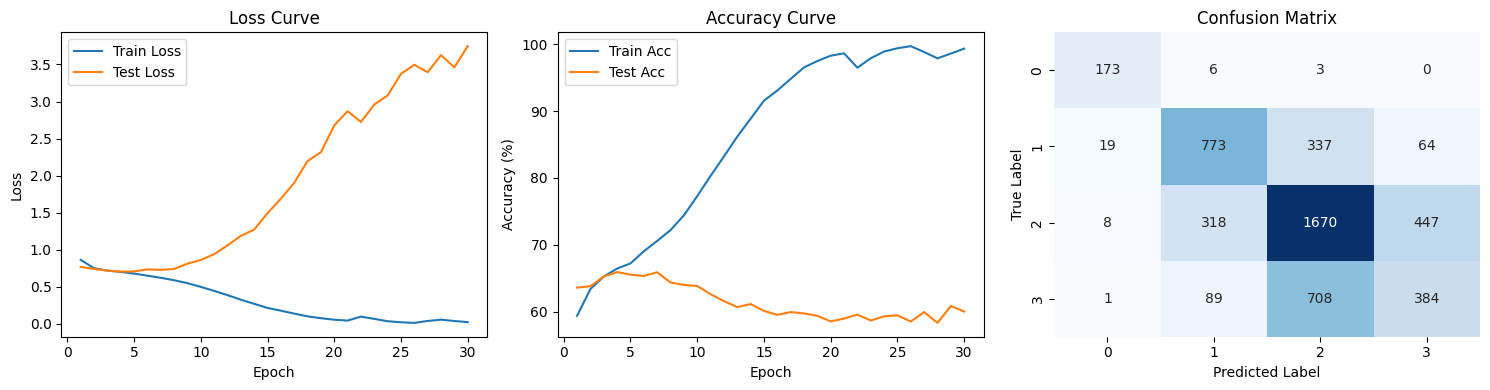

In [27]:
# Define model
n_timepoints = x_train.shape[1]
n_classes = len(np.unique(y_train))
model = CNNClassifier(n_timepoints, n_classes)

fit(model, train_loader, test_loader)

In [28]:
cell_trace = extract_cell_timetrace('C:/Users/vpming/tuni_ml/data/stim_1.0_beta_0.40_noise_0.01_kcross_0.0050\sim_data__stimMag_1.00_beta_0.40_noise_0.010_kcross_0.0050_nSamples_1000_4.h5', 17)
cell_trace_scaled = x_scaler.transform(cell_trace.reshape(1, -1))
with torch.no_grad():
    logits = model(torch.tensor(cell_trace_scaled, dtype=torch.float32))
    pred_class = logits.argmax(dim=1).item()

print(pred_class)

1
